In [45]:
import pydicom as pdc
import matplotlib.pyplot as plt
from IPython.display import display, Image
import numpy as np
import cv2
import pandas as pd
from sklearn import preprocessing
from sklearn.model_selection import KFold
import tensorflow as tf
import keras
from keras.utils import to_categorical
from keras.layers import Dense, Flatten, Conv3D, MaxPooling3D, Dropout
from tensorflow.keras import layers
import tensorflow_hub as hub
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [46]:
# Load Dataset
path = '../Code/benchmark_liver_tumor/raw/np/'
X_p_tr, X_m_tr, X_i_tr, Y_tr = np.load(path+'X_p_tr.npy'), np.load(path+'X_m_tr.npy', allow_pickle=True), np.load(path+'X_i_tr.npy'), np.load(path+'Y_tr.npy')
X_p_te, X_m_te, X_i_te, Y_te = np.load(path+'X_p_te.npy'), np.load(path+'X_m_te.npy', allow_pickle=True), np.load(path+'X_i_te.npy'), np.load(path+'Y_te.npy')
X_m_tr, X_m_te = X_m_tr.astype('float32'), X_m_te.astype('float32')
Y_tr_cat, Y_te_cat = to_categorical(Y_tr), to_categorical(Y_te) # one-hot-encode
print(X_p_tr.shape, X_m_tr.shape, X_i_tr.shape, Y_tr.shape, Y_tr_cat.shape)
print(X_p_te.shape, X_m_te.shape, X_i_te.shape, Y_te.shape, Y_te_cat.shape)

(10843,) (10843, 6) (10843, 3, 96, 96) (10843,) (10843, 3)
(2764,) (2764, 6) (2764, 3, 96, 96) (2764,) (2764, 3)


In [47]:
# Permute Channels
X_i_tr = np.rollaxis(X_i_tr, 1, 4)
X_i_te = np.rollaxis(X_i_te, 1, 4)
print(X_i_tr.shape)
print(X_i_te.shape)

(10843, 96, 96, 3)
(2764, 96, 96, 3)


In [48]:
# inception v3
import tensorflow_hub as hub
# Download the classifier
URL = "https://tfhub.dev/google/imagenet/inception_v3/feature_vector/4"

In [49]:
from tensorflow.keras.applications.inception_v3 import InceptionV3

local_weights_file= './inceptionV3/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5'

pre_trained_model = InceptionV3(input_shape = (96, 96, 3),
                                include_top = False,
                                weights = None)

pre_trained_model.load_weights(local_weights_file)

for layer in pre_trained_model.layers:
    layer.trainable = False
last_layer = pre_trained_model.get_layer('mixed7')
last_output = last_layer.output

# Flatten the output layer to 1 dimension
x = layers.Flatten()(last_output)
# Add a fully connected layer with 1,024 hidden units and ReLU activation
x = layers.Dense(1024, activation='relu')(x)
# Add a dropout rate of 0.5
x = layers.Dropout(0.5)(x)                  
inc_v3_output = tf.keras.layers.Dense(Y_tr_cat.shape[1], activation='softmax')(x)

model = tf.keras.Model(pre_trained_model.input, inc_v3_output)
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()


Model: "functional_15"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_18 (InputLayer)           [(None, 96, 96, 3)]  0                                            
__________________________________________________________________________________________________
conv2d_1598 (Conv2D)            (None, 47, 47, 32)   864         input_18[0][0]                   
__________________________________________________________________________________________________
batch_normalization_1598 (Batch (None, 47, 47, 32)   96          conv2d_1598[0][0]                
__________________________________________________________________________________________________
activation_1598 (Activation)    (None, 47, 47, 32)   0           batch_normalization_1598[0][0]   
______________________________________________________________________________________

In [50]:
from keras.callbacks import EarlyStopping
es = EarlyStopping(monitor='accuracy', patience=5, restore_best_weights=True)
model_history = model.fit(X_i_tr, Y_tr_cat, validation_data=(X_i_te, Y_te_cat), epochs=20, batch_size=512, shuffle=True, verbose=2, callbacks=[es])


Epoch 1/20
22/22 - 25s - loss: 2.2367 - accuracy: 0.6020 - val_loss: 1.1120 - val_accuracy: 0.6201
Epoch 2/20
22/22 - 23s - loss: 0.5983 - accuracy: 0.7595 - val_loss: 0.9866 - val_accuracy: 0.6248
Epoch 3/20
22/22 - 25s - loss: 0.4611 - accuracy: 0.8198 - val_loss: 1.0748 - val_accuracy: 0.6440
Epoch 4/20
22/22 - 25s - loss: 0.3691 - accuracy: 0.8679 - val_loss: 1.1628 - val_accuracy: 0.6444
Epoch 5/20
22/22 - 27s - loss: 0.2997 - accuracy: 0.8945 - val_loss: 1.2706 - val_accuracy: 0.6252
Epoch 6/20
22/22 - 26s - loss: 0.2292 - accuracy: 0.9263 - val_loss: 1.3957 - val_accuracy: 0.6339
Epoch 7/20
22/22 - 27s - loss: 0.1855 - accuracy: 0.9443 - val_loss: 1.2943 - val_accuracy: 0.6541
Epoch 8/20
22/22 - 26s - loss: 0.1602 - accuracy: 0.9529 - val_loss: 1.4186 - val_accuracy: 0.6483
Epoch 9/20
22/22 - 28s - loss: 0.1246 - accuracy: 0.9677 - val_loss: 1.5879 - val_accuracy: 0.6400
Epoch 10/20
22/22 - 26s - loss: 0.1035 - accuracy: 0.9746 - val_loss: 1.5898 - val_accuracy: 0.6397
Epoch 11/

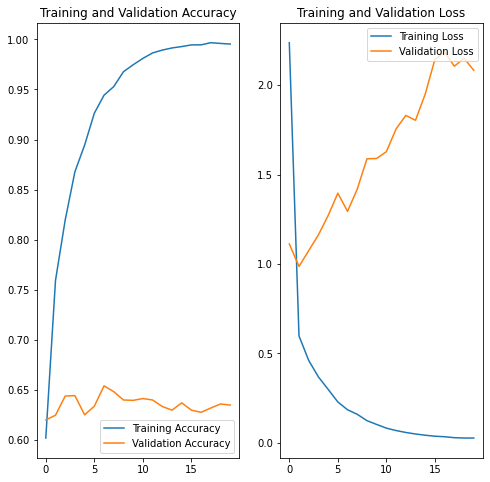

In [52]:
epochs = 20
# Evaluation 
acc = model_history.history['accuracy']
val_acc = model_history.history['val_accuracy']
loss = model_history.history['loss']
val_loss = model_history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()